### libraries
 
- `numpy` for numerical operations
- `tensorflow` for dataset loading 
- `sklearn.metrics` for evaluation
- `matplotlib.pyplot` for plotting.


In [34]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import math

### Data Loading and Preprocessing

The `load_and_preprocess_data_multiclass` function handles:
- Loading the **CIFAR-10 dataset**.
- Normalizing image pixel values to the [0, 1] range.
- Flattening images into vectors.
- **One-hot encoding** the labels for multiclass classification.
- Splitting the training data into training and validation sets.
It returns processed training, validation, and test sets, along with original integer labels for the test set for evaluation.

In [35]:
def load_and_preprocess_data_binary(validation_split_ratio=0.1):
    (x_train_orig, y_train_orig), (x_test_orig, y_test_orig) = \
        tf.keras.datasets.cifar10.load_data()

    print(f"Initial training data size: {x_train_orig.shape[0]}")
    print(f"Initial test data size: {x_test_orig.shape[0]}")

    x_train_normalized = x_train_orig.astype('float32') / 255.0
    x_test_normalized = x_test_orig.astype('float32') / 255.0

    x_train_flattened = x_train_normalized.reshape(x_train_normalized.shape[0], -1)
    x_test_flattened = x_test_normalized.reshape(x_test_normalized.shape[0], -1)

    # Binary classification: 1 for airplane (label 0), 0 for others
    y_train_binary = np.where(y_train_orig == 0, 1, 0).astype('float32')
    y_test_binary = np.where(y_test_orig == 0, 1, 0).astype('float32')

    num_train_samples = x_train_flattened.shape[0]
    permutation = np.random.permutation(num_train_samples)
    shuffled_X = x_train_flattened[permutation]
    shuffled_Y_binary = y_train_binary[permutation]

    split_index = int(num_train_samples * (1 - validation_split_ratio))

    x_train_final = shuffled_X[:split_index]
    y_train_final = shuffled_Y_binary[:split_index]
    x_val = shuffled_X[split_index:]
    y_val = shuffled_Y_binary[split_index:]

    print("--- Processed Data Shapes ---")
    print(f"x_train_final: {x_train_final.shape}, y_train_final: {y_train_final.shape}")
    print(f"x_val: {x_val.shape}, y_val: {y_val.shape}")
    print(f"x_test_flattened: {x_test_flattened.shape}, y_test_binary: {y_test_binary.shape}")
    print("-----------------------------")

    return x_train_final, y_train_final, x_val, y_val, x_test_flattened, y_test_binary

### Activation and Loss Functions

Defines the `sigmoid` activation function ( $ \sigma(z) = \frac{1}{1 + e^{-z}} $ ) and the `binary_cross_entropy_loss` function. The loss function includes clipping to prevent `log(0)`.

In [36]:
def sigmoid(z):
    z_clipped = np.clip(z, -500, 500) # Avoid overflow/underflow
    s = 1 / (1 + np.exp(-z_clipped))
    return s

def binary_cross_entropy_loss(y_true, y_pred):
    m = y_true.shape[1]
    epsilon = 1e-12
    y_pred_clipped = np.clip(y_pred, epsilon, 1. - epsilon)
    cost = - (1 / m) * np.sum(y_true * np.log(y_pred_clipped) + (1 - y_true) * np.log(1 - y_pred_clipped))
    return np.squeeze(cost)

### Neural Network Implementation

This section contains functions for a simple one-hidden-layer neural network:
- `define_layer_sizes_binary`: Sets the input, hidden, and output layer sizes.
- `initialize_parameters_binary`: Initializes weights (He initialization) and biases.
- `forward_propagation_binary`: Computes the forward pass ($Z^{[1]}, A^{[1]}, Z^{[2]}, A^{[2]}$). Sigmoid activation is used for both hidden and output layers.
- `backward_propagation_binary`: Computes gradients ($dW^{[1]}, db^{[1]}, dW^{[2]}, db^{[2]}$).
- `update_parameters`: Updates model parameters using gradient descent.

In [37]:
def define_layer_sizes_binary(X_shape_cols, n_h):
    n_x = X_shape_cols
    n_y = 1 # Binary classification
    return n_x, n_h, n_y

def initialize_parameters_binary(n_x, n_h, n_y):
    np.random.seed(42) # For reproducibility
    W1 = np.random.randn(n_h, n_x) * np.sqrt(2. / n_x) # He initialization
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * np.sqrt(2. / n_h) # He initialization
    b2 = np.zeros((n_y, 1))
    return {"W1": W1, "b1": b1, "W2": W2, "b2": b2}

def forward_propagation_binary(X_input, parameters):
    W1, b1, W2, b2 = parameters["W1"], parameters["b1"], parameters["W2"], parameters["b2"]
    Z1 = np.dot(W1, X_input) + b1
    A1 = sigmoid(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2) 
    cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}
    return A2, cache

def backward_propagation_binary(parameters, cache, X_input, Y_binary_true):
    m = X_input.shape[1]
    W2 = parameters["W2"]
    A1, A2 = cache["A1"], cache["A2"]

    dZ2 = A2 - Y_binary_true
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)

    dA1 = np.dot(W2.T, dZ2)
    dZ1 = dA1 * (A1 * (1 - A1)) 
    dW1 = (1 / m) * np.dot(dZ1, X_input.T)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)

    return {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

def update_parameters(parameters, grads, learning_rate):
    updated_params = {}
    for key in parameters.keys():
        updated_params[key] = parameters[key] - learning_rate * grads['d' + key]
    return updated_params

### Model Training and Evaluation

- `create_minibatches`: Splits data into mini-batches for stochastic gradient descent.
- `nn_model_binary_advanced`: Orchestrates the training of the neural network. It uses mini-batch gradient descent, calculates validation loss for early stopping, and evaluates the model on the test set using metrics like F1-score, precision, recall, and accuracy.

In [38]:
def create_minibatches(X_input, Y_labels, minibatch_size=128, seed=0):
    np.random.seed(seed)
    m = X_input.shape[1]
    minibatches = []
    permutation = list(np.random.permutation(m))
    shuffled_X = X_input[:, permutation]
    shuffled_Y = Y_labels[:, permutation].reshape((Y_labels.shape[0], m))

    num_complete_minibatches = math.floor(m / minibatch_size)
    for k in range(num_complete_minibatches):
        minibatch_X = shuffled_X[:, k * minibatch_size : (k + 1) * minibatch_size]
        minibatch_Y = shuffled_Y[:, k * minibatch_size : (k + 1) * minibatch_size]
        minibatches.append((minibatch_X, minibatch_Y))

    if m % minibatch_size != 0:
        minibatch_X = shuffled_X[:, num_complete_minibatches * minibatch_size : m]
        minibatch_Y = shuffled_Y[:, num_complete_minibatches * minibatch_size : m]
        minibatches.append((minibatch_X, minibatch_Y))
    return minibatches

In [39]:
def nn_model_binary(
        X_train_data, Y_train_labels, X_val_data, Y_val_labels, X_test_data, Y_test_labels,
        n_h, num_epochs=100, minibatch_size=128, learning_rate=0.01,
        patience_early_stopping=10, print_cost_every_n_epochs=1
):
    # Input data: (num_samples, num_features), labels: (num_samples, 1)
    # Internal calculations use transposed data: (num_features/classes, num_samples)
    X_train_t = X_train_data.T
    Y_train_t = Y_train_labels.T.reshape(1, -1)
    X_val_t = X_val_data.T
    Y_val_t = Y_val_labels.T.reshape(1, -1)
    X_test_t = X_test_data.T
    Y_test_t = Y_test_labels.T.reshape(1, -1)

    n_x, _, n_y = define_layer_sizes_binary(X_train_data.shape[1], n_h)
    parameters = initialize_parameters_binary(n_x, n_h, n_y)

    train_costs, val_costs = [], []
    best_val_cost = float('inf')
    epochs_no_improve = 0
    best_parameters = parameters.copy()
    current_seed = 0
    actual_epochs_run = 0

    print(f"\n--- Training Binary Neural Network ---")
    print(f"Architecture: Input={n_x}, Hidden={n_h}, Output={n_y}")
    print(f"Epochs={num_epochs}, LR={learning_rate}, BatchSize={minibatch_size}, Patience={patience_early_stopping}\n")

    for epoch in range(num_epochs):
        actual_epochs_run = epoch + 1
        current_seed += 1
        epoch_cost_sum = 0
        minibatches = create_minibatches(X_train_t, Y_train_t, minibatch_size, current_seed)

        for minibatch_X, minibatch_Y in minibatches:
            A2_mini, cache_mini = forward_propagation_binary(minibatch_X, parameters)
            cost_mini = binary_cross_entropy_loss(minibatch_Y, A2_mini)
            epoch_cost_sum += cost_mini
            grads = backward_propagation_binary(parameters, cache_mini, minibatch_X, minibatch_Y)
            parameters = update_parameters(parameters, grads, learning_rate)

        avg_train_cost = epoch_cost_sum / len(minibatches)
        train_costs.append(avg_train_cost)

        A2_val, _ = forward_propagation_binary(X_val_t, parameters)
        current_val_cost = binary_cross_entropy_loss(Y_val_t, A2_val)
        val_costs.append(current_val_cost)

        if (epoch + 1) % print_cost_every_n_epochs == 0 or epoch == num_epochs -1:
            print(f"Epoch {epoch+1}/{num_epochs} - Train Cost: {avg_train_cost:.6f} - Val Cost: {current_val_cost:.6f}")

        if current_val_cost < best_val_cost:
            best_val_cost = current_val_cost
            best_parameters = {k: v.copy() for k, v in parameters.items()} # Deep copy
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience_early_stopping:
                print(f"Early stopping: Epoch {epoch+1}. Best val cost: {best_val_cost:.6f}")
                parameters = best_parameters
                break
    parameters = best_parameters

    A2_test, _ = forward_propagation_binary(X_test_t, parameters)
    Y_pred_test = (A2_test > 0.5).astype(float).flatten()
    Y_test_flat = Y_test_labels.flatten()

    print(f"\n--- Model Evaluation ---")
    cm = confusion_matrix(Y_test_flat, Y_pred_test)
    f1 = f1_score(Y_test_flat, Y_pred_test, zero_division=0)
    precision = precision_score(Y_test_flat, Y_pred_test, zero_division=0)
    recall = recall_score(Y_test_flat, Y_pred_test, zero_division=0)
    accuracy = np.mean(Y_pred_test == Y_test_flat) * 100

    print("Confusion Matrix (Test):\n", cm)
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
    print(f"Overall Test Accuracy: {accuracy:.2f}%")

    history = {"train_costs": train_costs, "val_costs": val_costs, "epochs_run": actual_epochs_run}
    results = {"parameters": parameters, "history": history, "learning_rate": learning_rate,
               "num_epochs_conf": num_epochs, "n_h": n_h, "accuracy": accuracy,
               "minibatch_size": minibatch_size, "f1": f1, "precision": precision, "recall": recall}
    return results

### Plotting Function

The `plot_train_val_costs_binary` function visualizes the training and validation loss curves over epochs. This helps in diagnosing issues like overfitting or underfitting.


In [40]:
def plot_train_val_costs_binary(history_data, lr, n_h_nodes, batch_s):
    train_c = history_data["train_costs"]
    val_c = history_data["val_costs"]
    epochs_r = range(1, history_data["epochs_run"] + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs_r, train_c, label='Training Cost', marker='.')
    plt.plot(epochs_r, val_c, label='Validation Cost', marker='.')
    plt.ylabel('Cost (Binary Cross-Entropy)')
    plt.xlabel('Epochs')
    plt.title(f'Cost Curve (Hidden: {n_h_nodes}, LR: {lr}, Batch: {batch_s})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Main Execution

This block sets up hyperparameters, loads data, trains the neural network model using `nn_model_binary`, plots the cost curves, and prints a summary of the final results.

Initial training data size: 50000
Initial test data size: 10000
--- Processed Data Shapes ---
x_train_final: (42500, 3072), y_train_final: (42500, 1)
x_val: (7500, 3072), y_val: (7500, 1)
x_test_flattened: (10000, 3072), y_test_binary: (10000, 1)
-----------------------------

--- Training Binary Neural Network ---
Architecture: Input=3072, Hidden=32, Output=1
Epochs=1000, LR=0.005, BatchSize=128, Patience=15

Epoch 10/1000 - Train Cost: 0.301910 - Val Cost: 0.302764
Epoch 20/1000 - Train Cost: 0.275033 - Val Cost: 0.276749
Epoch 30/1000 - Train Cost: 0.265917 - Val Cost: 0.268747
Epoch 40/1000 - Train Cost: 0.262191 - Val Cost: 0.265780
Epoch 50/1000 - Train Cost: 0.260360 - Val Cost: 0.263731
Epoch 60/1000 - Train Cost: 0.257883 - Val Cost: 0.261954
Epoch 70/1000 - Train Cost: 0.255732 - Val Cost: 0.259844
Epoch 80/1000 - Train Cost: 0.253851 - Val Cost: 0.257959
Epoch 90/1000 - Train Cost: 0.253111 - Val Cost: 0.256013
Epoch 100/1000 - Train Cost: 0.250383 - Val Cost: 0.255947
Epoch

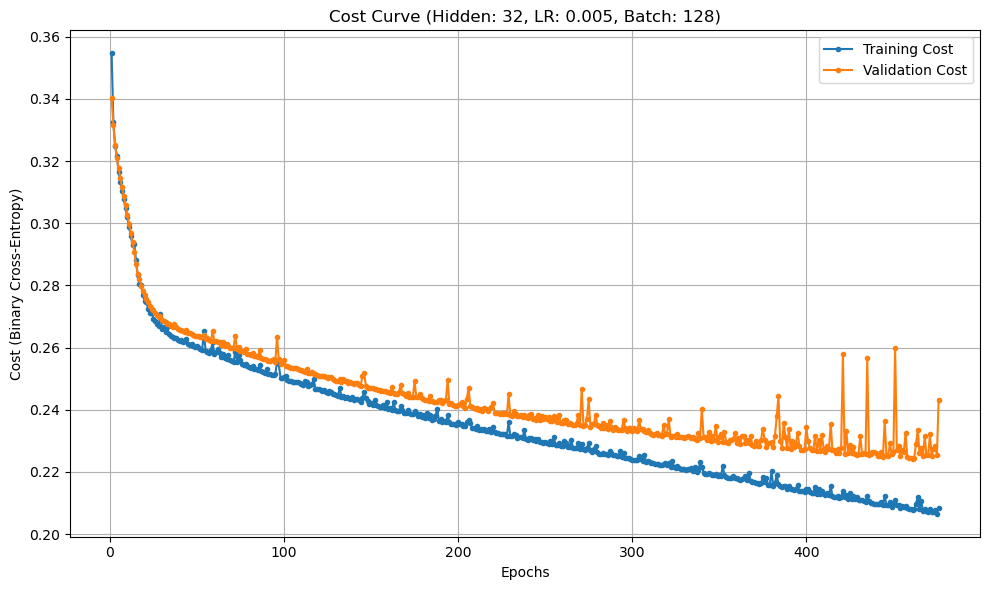


--- Final Summary ---
Hidden Neurons: 32
Learning Rate: 0.005, Configured Epochs: 1000
Epochs Run: 476
Mini-batch Size: 128
Test Accuracy: 92.01%
Test F1: 0.4272, Precision: 0.7544, Recall: 0.2980


In [41]:
if __name__ == "__main__":
    x_train, y_train, x_val, y_val, x_test, y_test = \
        load_and_preprocess_data_binary(validation_split_ratio=0.15) # Example: 15% validation

    # Hyperparameters
    HIDDEN_LAYER_NODES = 32 # Number of neurons in the hidden layer
    NUM_EPOCHS = 1000       # Max number of training iterations
    LEARNING_RATE = 0.005   # Step size for gradient descent
    MINIBATCH_SIZE = 128    # Number of examples in each mini-batch
    PATIENCE = 15          # Epochs to wait for improvement before early stopping
    PRINT_EVERY = 10       # Frequency of printing training progress

    model_results = nn_model_binary(
        x_train, y_train, x_val, y_val, x_test, y_test,
        n_h=HIDDEN_LAYER_NODES,
        num_epochs=NUM_EPOCHS,
        minibatch_size=MINIBATCH_SIZE,
        learning_rate=LEARNING_RATE,
        patience_early_stopping=PATIENCE,
        print_cost_every_n_epochs=PRINT_EVERY
    )

    if model_results and "history" in model_results:
        plot_train_val_costs_binary(
            model_results["history"],
            model_results["learning_rate"],
            model_results["n_h"],
            model_results["minibatch_size"]
        )

    print(f"\n--- Final Summary ---")
    if model_results:
        print(f"Hidden Neurons: {model_results['n_h']}")
        print(f"Learning Rate: {model_results['learning_rate']}, Configured Epochs: {model_results['num_epochs_conf']}")
        print(f"Epochs Run: {model_results['history']['epochs_run']}")
        print(f"Mini-batch Size: {model_results['minibatch_size']}")
        print(f"Test Accuracy: {model_results['accuracy']:.2f}%")
        print(f"Test F1: {model_results['f1']:.4f}, Precision: {model_results['precision']:.4f}, Recall: {model_results['recall']:.4f}")
    else:
        print("Model training did not produce results.")